# Task 2 - Natural Language Processing

## Structured Perceptron

### Rubén Barco Terrones - Aleix Casellas Comas - Andreu Masdeu Ninot - Pablo Lázaro Herrasti

##### Imports

In [1]:
#### Basics
import pandas as pd
import numpy as np
%matplotlib inline

import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#### skseq Sequences
import scipy
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import skseq
from skseq.sequences import sequence
from skseq.sequences.sequence import Sequence
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary

#### Feature mapper
import pprint
from skseq.sequences import extended_feature

#### Structured perceptron
import skseq.readers.pos_corpus
import skseq.sequences.structured_perceptron as spc

#### Functions:

In [2]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# TRAINING/TEST PREPROCESSING (NER_DATASET)

In [3]:
# data = pd.read_csv("ner_dataset.csv",encoding="latin1")
# data.head()

### Preparing data

In [4]:
def build_word_to_pos(X):

    word_to_pos = {}
    i = 0
    for s in X:
        for w in s:
            if w not in word_to_pos:
                word_to_pos[w] = i
                i +=1
                
    pos_to_word = {v: k for k, v in word_to_pos.items()}
    return word_to_pos, pos_to_word
            
def build_tag_to_pos(Y):
    tag_to_pos = {}
    i = 0
    for s in Y:
        for t in s:
            if t not in tag_to_pos:
                tag_to_pos[t] = i
                i +=1
    pos_to_tag = {v: k for k, v in tag_to_pos.items()}

    return tag_to_pos, pos_to_tag

### Train

In [5]:
# sentence_formatter = "Sentence: {}"

# last_n_train = 35971
# end_train   = data.index[data["Sentence #"] == sentence_formatter.format(last_n_train)][0]
# train = data[0:end_train]

# n_sentences_train = len(list(set(train["Sentence #"])))
# first_n_train = 1
# last_n_train = last_n_train -1
# print(n_sentences)

In [6]:
# n_sentences_train = len(list(set(train["Sentence #"])))

In [7]:
# %%time 
# sentence_formatter = "Sentence: {}"

# for s_id in  range(first_n_train, last_n_train):
#     print("current {}/{}".format(s_id,last_n_train), end="\r")
#     sentence_id = sentence_formatter.format(s_id)
#     sentence_id_next = sentence_formatter.format(s_id + 1)
#     start = train.index[train["Sentence #"] == sentence_id][0]
#     end   = train.index[train["Sentence #"] == sentence_id_next][0]
#     train["Sentence #"][start:end] = sentence_id
    
# sentence_id = sentence_formatter.format(last_n_train)
# start = train.index[train["Sentence #"] == sentence_id][0]
# end   = train.shape[0]
# train["Sentence #"][start:end] = sentence_id

In [8]:
# train.to_csv('train.csv', sep='\t')

In [9]:
# X_train = []
# Y_train = []

# sentence_formatter = "Sentence: {}"

# for i in range(1,n_sentences_train):
#     s = sentence_formatter.format(i)
#     X_train.append(list(train[train["Sentence #"]==s]["Word"].values))
#     Y_train.append(list(train[train["Sentence #"]==s]["Tag"].values))

In [10]:
# with open("X_train.txt", "wb") as fp:   #Pickling
#     pickle.dump(X_train, fp)
# with open("Y_train.txt", "wb") as fp:   #Pickling
#     pickle.dump(Y_train, fp)

In [11]:
with open("X_train.txt", "rb") as fp:   # Unpickling
    X_train = pickle.load(fp)
with open("Y_train.txt", "rb") as fp:   # Unpickling
    Y_train = pickle.load(fp)

In [12]:
i = 0
xy = ["{}/{}".format(x,y) for x,y in zip(X_train[i],Y_train[i])]
" ".join(xy)

'Thousands/O of/O demonstrators/O have/O marched/O through/O London/B-geo to/O protest/O the/O war/O in/O Iraq/B-geo and/O demand/O the/O withdrawal/O of/O British/B-gpe troops/O from/O that/O country/O ./O'

In [13]:
word_to_pos, pos_to_word = build_word_to_pos(X_train)
tag_to_pos, pos_to_tag  = build_tag_to_pos(Y_train)

len(word_to_pos), len(tag_to_pos)

(30863, 17)

In [14]:
X_ids_train = [[word_to_pos[w] for w in s] for s in X_train]
Y_ids_train = [[tag_to_pos[t] for t in s] for s in Y_train]

In [15]:
# sequence_list = SequenceList(LabelDictionary(word_to_pos), LabelDictionary(tag_to_pos))
# for x,y in zip(X_train,Y_train):
#     sequence_list.add_sequence(x,y, LabelDictionary(word_to_pos), LabelDictionary(tag_to_pos))

In [16]:
# sequence_list[0].to_words(sequence_list=sequence_list)

In [17]:
# with open('sequence_list_train', 'wb') as sqq:
 
#     pickle.dump(sequence_list, sqq)

In [18]:
with open("sequence_list_train", "rb") as fp:   # Unpickling
    sequence_list_train = pickle.load(fp)

In [19]:
sequence_list_train[3]

49/0 50/0 9/0 51/0 1/0 52/0 53/0 54/0 55/0 56/0 57/0 58/0 59/0 60/0 21/0 

### Test

In [20]:
# sentence_formatter = "Sentence: {}"

# test = data[end_train:len(data)]

# n_sentences_test = len(list(set(test["Sentence #"])))
# first_n_test = last_n_train + 1
# last_n_test = 47959
# print(n_sentences_test)

In [21]:
# %%time 
# sentence_formatter = "Sentence: {}"

# for s_id in  range(first_n_test, last_n_test):
#     print("current {}/{}".format(s_id,last_n_test), end="\r")
#     sentence_id = sentence_formatter.format(s_id)
#     sentence_id_next = sentence_formatter.format(s_id + 1)
#     start = data.index[data["Sentence #"] == sentence_id][0]
#     end   = data.index[data["Sentence #"] == sentence_id_next][0]
#     data["Sentence #"][start:end] = sentence_id
    
# sentence_id = sentence_formatter.format(last_n_test)
# start = data.index[data["Sentence #"] == sentence_id][0]
# end   = data.shape[0]
# data["Sentence #"][start:end] = sentence_id

In [22]:
# test.to_csv('test.csv', sep='\t')

In [23]:
# X_test = []
# Y_test = []

# sentence_formatter = "Sentence: {}"

# for i in range(n_sentences_train+1,n_sentences_train+n_sentences_test-1):
#     s = sentence_formatter.format(i)
#     X_test.append(list(data[data["Sentence #"]==s]["Word"].values))
#     Y_test.append(list(data[data["Sentence #"]==s]["Tag"].values))

In [24]:
# with open("X_test.txt", "wb") as fp:   #Pickling
#     pickle.dump(X_test, fp)
# with open("Y_test.txt", "wb") as fp:   #Pickling
#     pickle.dump(Y_test, fp)

In [25]:
with open("X_test.txt", "rb") as fp:   # Unpickling
    X_test = pickle.load(fp)
with open("Y_test.txt", "rb") as fp:   # Unpickling
    Y_test = pickle.load(fp)

In [26]:
i = 0
xy = ["{}/{}".format(x,y) for x,y in zip(X_test[i],Y_test[i])]
" ".join(xy)

'Officials/O said/O Sunday/B-tim Jean/B-per Rene/I-per Anthony/I-per was/O killed/O in/O a/O shootout/O with/O police/O near/O the/O capital/O city/O of/O Port-au-Prince/B-geo ./O'

In [27]:
Y_ids_test = [[tag_to_pos[t] for t in s] for s in Y_test]

In [28]:
test_sentences = ["The programmers from Barcelona might write a sentence without a spell checker.", 
                  "The programmers from Barchelona cannot write a sentence without a spell checker.",
                  "Jack London went to Parris.",
                  "Jack London went to Paris.",
                  "We never though Microsoft would become such a big company.",
                  "We never though Microsof would become such a big company.",
                  "The president of U.S.A though they could win the war",
                  "The president of the United States of America though they could win the war",
                  "The king of Saudi Arabia wanted total control.",
                  "Robin does not want to go to Saudi Arabia."]

test_tags = [['O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
            ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
            ['B-per', 'I-per', 'O', 'O', 'O'],
            ['B-per', 'I-per', 'O', 'O', 'B-geo'],
            ['O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
            ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
            ['O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O'],
            ['O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'I-geo', 'I-geo', 'O', 'O', 'O', 'O', 'O', 'O'],
            ['O', 'O', 'O', 'B-geo', 'I-geo', 'O', 'O', 'O'],
            ['B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo']]

In [29]:
def print_all_test_sentences(test_sents, model):
    for sentence in test_sents:
        new_seq = Sequence(x=sentence.split(), y=[int(0) for w in sentence.split()])
        print(model.viterbi_decode(new_seq)[0].to_words(sequence_list_train, only_tag_translation=True))
            
def compare_one_test_sentence(test_sents, test_tgs, model, pos_to_tag, i):
    sentence = test_sents[i-1]
    new_seq = Sequence(x=sentence.split(), y=[int(0) for w in sentence.split()])
    preds = model.viterbi_decode(new_seq)[0].y
    print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
    for word, true_tag, pred_tag in zip(sentence.split(), test_tgs[i-1], preds):
        print("{:15} ({:5}): {}".format(word, true_tag, pos_to_tag[pred_tag]))

# EXPERIMENT 1: Basic features

##### Comments:
In this first experiment we are going to use only the **default features** in the ExtendedFeatures class. We want to have this experiment as the base experiment in order to be able to see the errors and how to solve them and to compare the future results with this one. 

### Extended features

In [30]:
ex_feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(sequence_list_train) 
ex_feature_mapper.build_features()
pprint.pprint(list(ex_feature_mapper.__dict__.keys()))

['feature_dict',
 'feature_list',
 'add_features',
 'dataset',
 'node_feature_cache',
 'initial_state_feature_cache',
 'final_state_feature_cache',
 'edge_feature_cache']


In [31]:
len(ex_feature_mapper.feature_dict)

38298

In [30]:
ex_feature_mapper.feature_dict

{'init_tag:O': 0,
 'id:Thousands::O': 1,
 'id:of::O': 2,
 'prev_tag:O::O': 3,
 'id:demonstrators::O': 4,
 'id:have::O': 5,
 'id:marched::O': 6,
 'id:through::O': 7,
 'id:London::B-geo': 8,
 'prev_tag:O::B-geo': 9,
 'id:to::O': 10,
 'prev_tag:B-geo::O': 11,
 'id:protest::O': 12,
 'id:the::O': 13,
 'id:war::O': 14,
 'id:in::O': 15,
 'id:Iraq::B-geo': 16,
 'id:and::O': 17,
 'id:demand::O': 18,
 'id:withdrawal::O': 19,
 'id:British::B-gpe': 20,
 'prev_tag:O::B-gpe': 21,
 'id:troops::O': 22,
 'prev_tag:B-gpe::O': 23,
 'id:from::O': 24,
 'id:that::O': 25,
 'id:country::O': 26,
 'id:.::O': 27,
 'final_prev_tag:O': 28,
 'id:Families::O': 29,
 'id:soldiers::O': 30,
 'id:killed::O': 31,
 'id:conflict::O': 32,
 'id:joined::O': 33,
 'id:protesters::O': 34,
 'id:who::O': 35,
 'id:carried::O': 36,
 'id:banners::O': 37,
 'id:with::O': 38,
 'id:such::O': 39,
 'id:slogans::O': 40,
 'id:as::O': 41,
 'id:"::O': 42,
 'id:Bush::B-per': 43,
 'prev_tag:O::B-per': 44,
 'id:Number::O': 45,
 'prev_tag:B-per::O'

#### Training structured perceptron

In [31]:
corpus = skseq.readers.pos_corpus.PostagCorpus()
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)

In [32]:
sp.get_num_states(), sp.get_num_observations()

(17, 30863)

In [33]:
%%time
num_epochs = 15
sp.fit(ex_feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.892678
Epoch: 1 Accuracy: 0.931972
Epoch: 2 Accuracy: 0.941622
Epoch: 3 Accuracy: 0.947549
Epoch: 4 Accuracy: 0.950647
Epoch: 5 Accuracy: 0.953512
Epoch: 6 Accuracy: 0.955472
Epoch: 7 Accuracy: 0.957134
Epoch: 8 Accuracy: 0.958280
Epoch: 9 Accuracy: 0.958821
Epoch: 10 Accuracy: 0.959816
Epoch: 11 Accuracy: 0.960872
Epoch: 12 Accuracy: 0.961597
Epoch: 13 Accuracy: 0.962109
Epoch: 14 Accuracy: 0.962987
Wall time: 1h 4min 12s


In [34]:
# sp.save_model("perceptron_ex1")

In [32]:
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)
sp.load_model(dir="perceptron_ex1")

#### Testing

In [36]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

y_pred_2 = []
y_true = [item for x in Y_ids_test for item in x]
correct_sentences = 0
n_test = len(X_test)

for i in range(n_test):
    y_pred_aux = sp.predict_tags_given_words(X_test[i])
    y_pred_2.append(y_pred_aux)
    if list(y_pred_aux) == Y_ids_test[i]:
        correct_sentences += 1
    
y_pred = [item for x in y_pred_2 for item in x]
F1_score_multi = f1_score(y_true, y_pred, average=None)
Accuracy = accuracy_score(y_true, y_pred)
print('Accuracy for test is: ' + str(Accuracy))
print('F1-Score for test is: ' + str(np.mean(F1_score_multi)))
print('Correct sentences for test (%) : ' + str(correct_sentences/n_test))

Accuracy for test is: 0.9497189411859115
F1-Score for test is: 0.6325282666272773
Correct sentences for test (%) : 0.4780613947280614


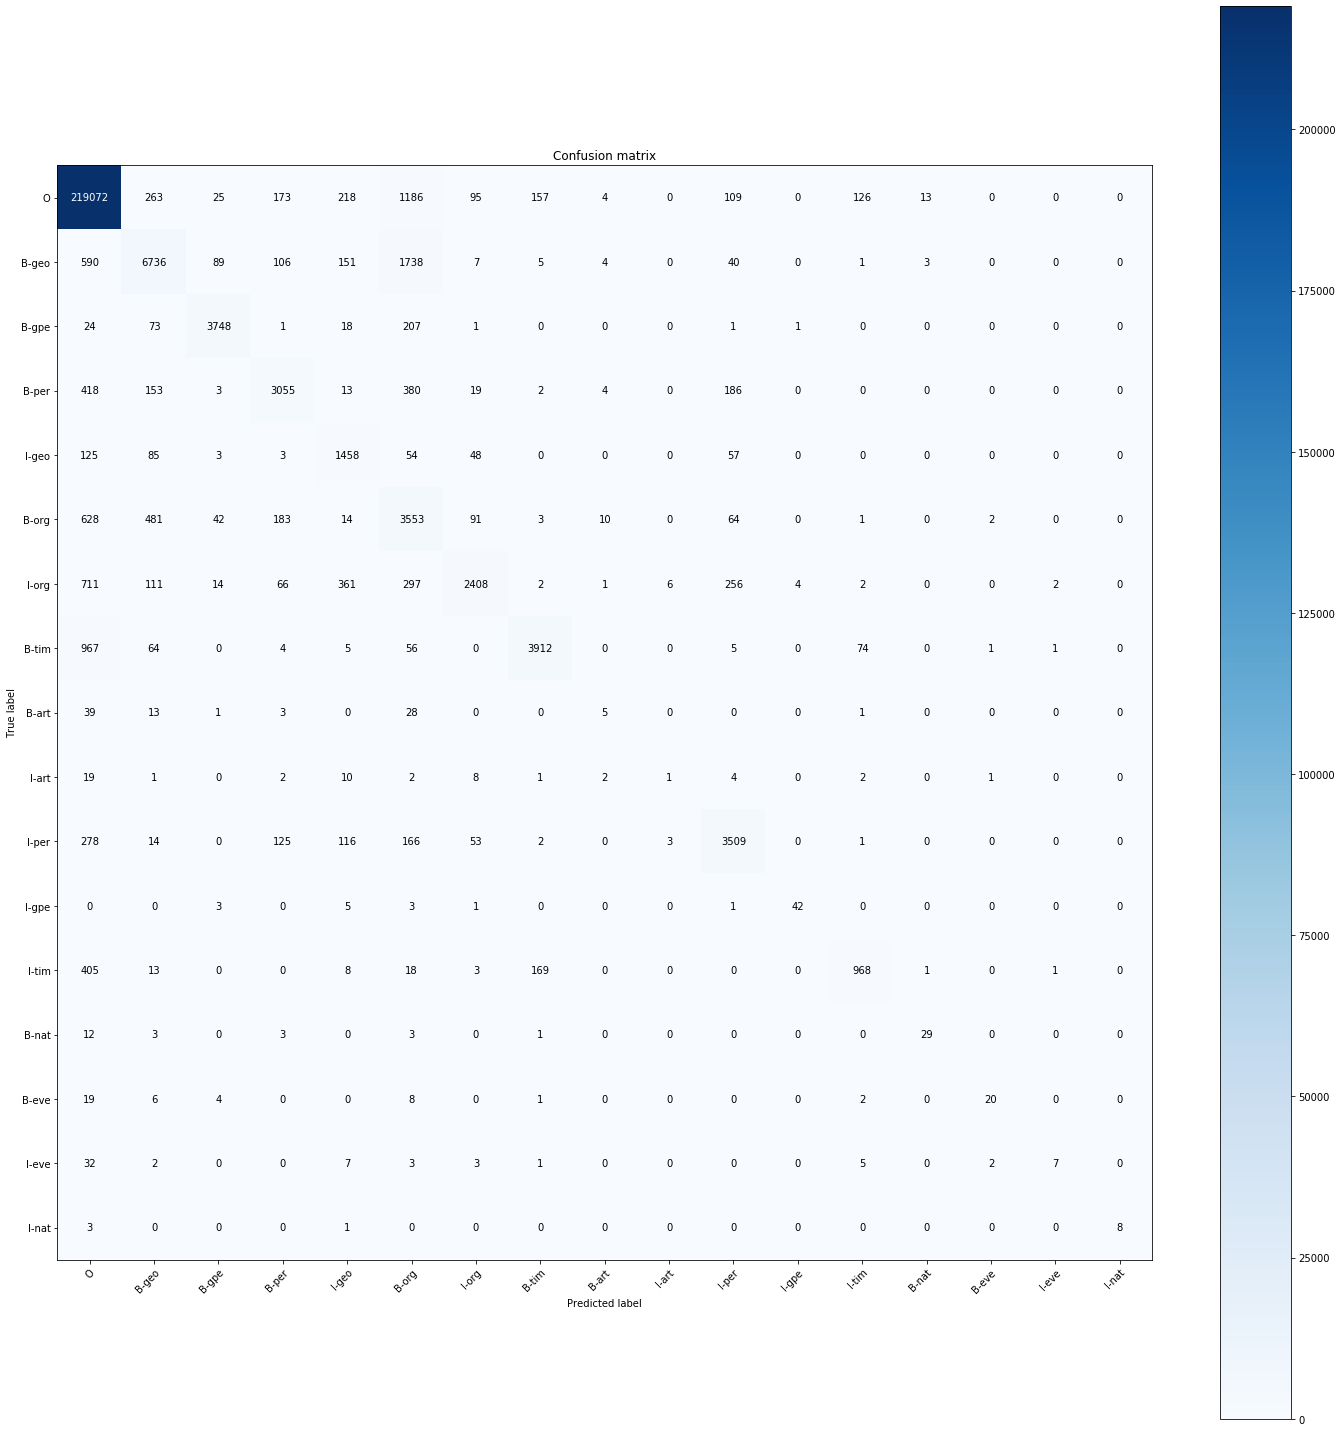

In [37]:
ax = plot_confusion_matrix(y_true, y_pred, classes=list(sp.state_labels),
                      title='Confusion matrix')

#### SENTENCES TO TEST THE MODEL

We think that these are the tags that the model should obtain:

1. The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O

2. The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/O checker./O

3. Jack/B-per London/I-per went/O to/O Parris./O

4. Jack/B-per London/I-per went/O to/O/O Paris./B-geo

5. We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O

6. We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O

7. The/O president/O of/O U.S.A/B-geo though/O they/O could/O win/O the/O war/O

8. The/O president/O of/O the/O United/B-geo States/B-geo of/B-geo America/B-geo though/O they/O could/O win/O the/O war/O

9. The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O

10. Robin/B-per does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia./I-geo


In [40]:
print_all_test_sentences(test_sentences, sp)

The/O programmers/O from/O Barcelona/B-org might/O write/O a/O sentence/O without/O a/O spell/B-per checker./I-per 
The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/B-per checker./I-per 
Jack/B-per London/B-geo went/O to/O Parris./O 
Jack/B-per London/B-geo went/O to/O Paris./O 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A/B-org though/O they/O could/O win/O the/O war/O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/B-org does/O not/O want/O to/O go/O to/O Saudi/O Arabia./O 


In [41]:
# Here we can select the sentence in which we want to compare the true and the predicted tags
# Select a sentence between 1 and 10
i=1
compare_one_test_sentence(test_sentences, test_tags, sp, pos_to_tag, i)

Word            (True ): Pred
The             (O    ): O
programmers     (O    ): O
from            (O    ): O
Barcelona       (B-geo): B-org
might           (O    ): O
write           (O    ): O
a               (O    ): O
sentence        (O    ): O
without         (O    ): O
a               (O    ): O
spell           (O    ): B-per
checker.        (O    ): I-per


#### Checking the first sentence of the corpus 

In [33]:
new_seq = Sequence(x=X_test[0], y=[int(0) for w in X_test[0]])
preds = sp.viterbi_decode(new_seq)[0].y
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for word, true_tag, pred_tag in zip(X_test[0], Y_test[0], preds):
    print("{:15} ({:5}): {}".format(word, true_tag, pos_to_tag[pred_tag]))

Word            (True ): Pred
Officials       (O    ): O
said            (O    ): O
Sunday          (B-tim): B-tim
Jean            (B-per): B-per
Rene            (I-per): I-per
Anthony         (I-per): I-per
was             (O    ): O
killed          (O    ): O
in              (O    ): O
a               (O    ): O
shootout        (O    ): O
with            (O    ): O
police          (O    ): O
near            (O    ): O
the             (O    ): O
capital         (O    ): O
city            (O    ): O
of              (O    ): O
Port-au-Prince  (B-geo): O
.               (O    ): O


##### Post-comments:

In the next experiment we are going to add a hyphen feature, because as we can see in the first sentence of the Test corpus (Port-au-Prince) we are failing.

# EXPERIMENT 2: Adding a hyphen

##### Comments:
In the second experiment we are going to introduce the **hyphen features** to check if this information is useful or not and if it helps with the previous error. 

### Extended features

In [30]:
ex_feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(sequence_list_train) 
ex_feature_mapper.build_features()
pprint.pprint(list(ex_feature_mapper.__dict__.keys()))

['feature_dict',
 'feature_list',
 'add_features',
 'dataset',
 'node_feature_cache',
 'initial_state_feature_cache',
 'final_state_feature_cache',
 'edge_feature_cache']


In [31]:
len(ex_feature_mapper.feature_dict)

38315

In [32]:
ex_feature_mapper.feature_dict

{'init_tag:O': 0,
 'id:Thousands::O': 1,
 'hyphen::O': 2,
 'id:of::O': 3,
 'prev_tag:O::O': 4,
 'id:demonstrators::O': 5,
 'id:have::O': 6,
 'id:marched::O': 7,
 'id:through::O': 8,
 'id:London::B-geo': 9,
 'hyphen::B-geo': 10,
 'prev_tag:O::B-geo': 11,
 'id:to::O': 12,
 'prev_tag:B-geo::O': 13,
 'id:protest::O': 14,
 'id:the::O': 15,
 'id:war::O': 16,
 'id:in::O': 17,
 'id:Iraq::B-geo': 18,
 'id:and::O': 19,
 'id:demand::O': 20,
 'id:withdrawal::O': 21,
 'id:British::B-gpe': 22,
 'hyphen::B-gpe': 23,
 'prev_tag:O::B-gpe': 24,
 'id:troops::O': 25,
 'prev_tag:B-gpe::O': 26,
 'id:from::O': 27,
 'id:that::O': 28,
 'id:country::O': 29,
 'id:.::O': 30,
 'final_prev_tag:O': 31,
 'id:Families::O': 32,
 'id:soldiers::O': 33,
 'id:killed::O': 34,
 'id:conflict::O': 35,
 'id:joined::O': 36,
 'id:protesters::O': 37,
 'id:who::O': 38,
 'id:carried::O': 39,
 'id:banners::O': 40,
 'id:with::O': 41,
 'id:such::O': 42,
 'id:slogans::O': 43,
 'id:as::O': 44,
 'id:"::O': 45,
 'id:Bush::B-per': 46,
 'hyp

In [33]:
[x for x in list(ex_feature_mapper.feature_dict.keys()) if 'hyphen' in x]

['hyphen::O',
 'hyphen::B-geo',
 'hyphen::B-gpe',
 'hyphen::B-per',
 'hyphen::I-geo',
 'hyphen::B-org',
 'hyphen::I-org',
 'hyphen::B-tim',
 'hyphen::B-art',
 'hyphen::I-art',
 'hyphen::I-per',
 'hyphen::I-gpe',
 'hyphen::I-tim',
 'hyphen::B-nat',
 'hyphen::B-eve',
 'hyphen::I-eve',
 'hyphen::I-nat']

#### Training structured perceptron

In [32]:
corpus = skseq.readers.pos_corpus.PostagCorpus()
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)

In [33]:
sp.get_num_states(), sp.get_num_observations()

(17, 30863)

In [34]:
%%time
num_epochs = 15
sp.fit(ex_feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.893649
Epoch: 1 Accuracy: 0.932477
Epoch: 2 Accuracy: 0.941703
Epoch: 3 Accuracy: 0.947204
Epoch: 4 Accuracy: 0.950647
Epoch: 5 Accuracy: 0.953267
Epoch: 6 Accuracy: 0.955126
Epoch: 7 Accuracy: 0.956926
Epoch: 8 Accuracy: 0.957718
Epoch: 9 Accuracy: 0.959740
Epoch: 10 Accuracy: 0.960284
Epoch: 11 Accuracy: 0.960919
Epoch: 12 Accuracy: 0.961542
Epoch: 13 Accuracy: 0.962344
Epoch: 14 Accuracy: 0.962593
Wall time: 1h 6min 44s


In [35]:
# sp.save_model("perceptron_ex2")

In [35]:
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)
sp.load_model(dir="perceptron_ex2")

#### Testing

In [37]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

y_pred_2 = []
y_true = [item for x in Y_ids_test for item in x]
correct_sentences = 0
n_test = len(X_test)

for i in range(n_test):
    y_pred_aux = sp.predict_tags_given_words(X_test[i])
    y_pred_2.append(y_pred_aux)
    if list(y_pred_aux) == Y_ids_test[i]:
        correct_sentences += 1
    
y_pred = [item for x in y_pred_2 for item in x]
F1_score_multi = f1_score(y_true, y_pred, average=None)
Accuracy = accuracy_score(y_true, y_pred)
print('Accuracy for test is: ' + str(Accuracy))
print('F1-Score for test is: ' + str(np.mean(F1_score_multi)))
print('Correct sentences for test (%) : ' + str(correct_sentences/n_test))

Accuracy for test is: 0.950487028495657
F1-Score for test is: 0.6293839019546097
Correct sentences for test (%) : 0.48373373373373374


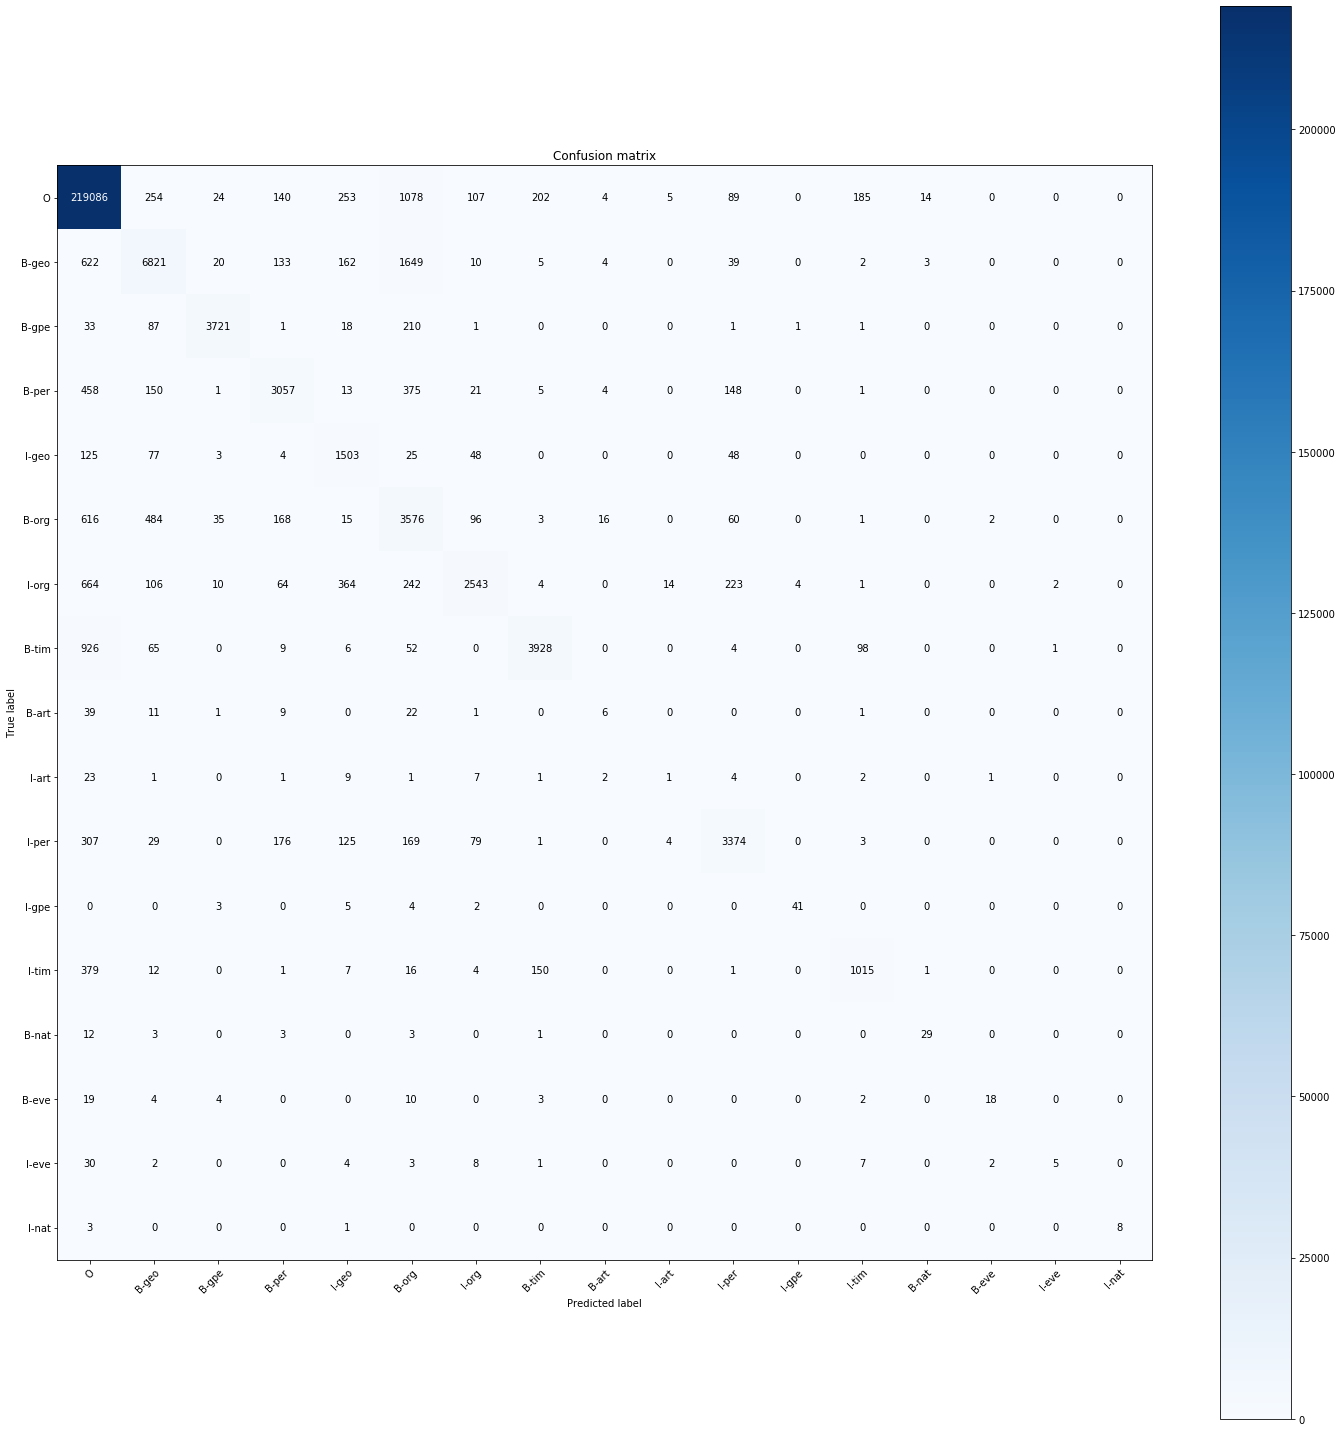

In [38]:
ax = plot_confusion_matrix(y_true, y_pred, classes=list(sp.state_labels),
                      title='Confusion matrix')

#### SENTENCES TO TEST THE MODEL

We think that these are the tags that the model should obtain:

1. The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O

2. The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/O checker./O

3. Jack/B-per London/I-per went/O to/O Parris./O

4. Jack/B-per London/I-per went/O to/O/O Paris./B-geo

5. We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O

6. We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O

7. The/O president/O of/O U.S.A/B-geo though/O they/O could/O win/O the/O war/O

8. The/O president/O of/O the/O United/B-geo States/B-geo of/B-geo America/B-geo though/O they/O could/O win/O the/O war/O

9. The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O

10. Robin/B-per does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia./I-geo


In [40]:
for sentence in test_sentences:
    new_seq = Sequence(x=sentence.split(), y=[int(0) for w in sentence.split()])
    print(sp.viterbi_decode(new_seq)[0].to_words(sequence_list_train, only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/B-per checker./I-per 
The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/B-per checker./I-per 
Jack/B-per London/B-geo went/O to/O Parris./O 
Jack/B-per London/B-geo went/O to/O Paris./O 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A/B-org though/O they/O could/O win/O the/O war/O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/B-org does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia./I-geo 


In [41]:
# Here we can select the sentence in which we want to compare the true and the predicted tags
# Select a sentence between 1 and 10
i=1
sentence = test_sentences[i-1]
new_seq = Sequence(x=sentence.split(), y=[int(0) for w in sentence.split()])
preds = sp.viterbi_decode(new_seq)[0].y
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for word, true_tag, pred_tag in zip(sentence.split(), test_tags[i-1], preds):
    print("{:15} ({:5}): {}".format(word, true_tag, pos_to_tag[pred_tag]))

Word            (True ): Pred
The             (O    ): O
programmers     (O    ): O
from            (O    ): O
Barcelona       (B-geo): B-geo
might           (O    ): O
write           (O    ): O
a               (O    ): O
sentence        (O    ): O
without         (O    ): O
a               (O    ): O
spell           (O    ): B-per
checker.        (O    ): I-per


#### Hyphen checking

In [37]:
new_seq = Sequence(x=X_test[0], y=[int(0) for w in X_test[0]])
preds = sp.viterbi_decode(new_seq)[0].y
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for word, true_tag, pred_tag in zip(X_test[0], Y_test[0], preds):
    print("{:15} ({:5}): {}".format(word, true_tag, pos_to_tag[pred_tag]))

Word            (True ): Pred
Officials       (O    ): O
said            (O    ): O
Sunday          (B-tim): B-tim
Jean            (B-per): B-geo
Rene            (I-per): O
Anthony         (I-per): B-gpe
was             (O    ): O
killed          (O    ): B-gpe
in              (O    ): O
a               (O    ): O
shootout        (O    ): B-gpe
with            (O    ): O
police          (O    ): B-gpe
near            (O    ): O
the             (O    ): O
capital         (O    ): B-gpe
city            (O    ): O
of              (O    ): O
Port-au-Prince  (B-geo): B-geo
.               (O    ): O


##### Post-comments:

As we can see we have fixed the error with the word Port-au-Prince. Now, we are going to fix the problem with capital letter at the begging. For example, when we have Jean Rene Anthony it does not recognize it as person. We are going to add in the next experiment a new feature with a capital letter at the beggining.

# EXPERIMENT 3: Adding a capital letter at the beggining

##### Comments:

Adding a **capital letter at the beggining** feature (without the point at the end) + Hyphen feature

### Extended features

In [30]:
ex_feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(sequence_list_train) 
ex_feature_mapper.build_features()
pprint.pprint(list(ex_feature_mapper.__dict__.keys()))

['feature_dict',
 'feature_list',
 'add_features',
 'dataset',
 'node_feature_cache',
 'initial_state_feature_cache',
 'final_state_feature_cache',
 'edge_feature_cache']


In [31]:
len(ex_feature_mapper.feature_dict)

38332

In [32]:
ex_feature_mapper.feature_dict

{'init_tag:O': 0,
 'id:Thousands::O': 1,
 'hyphen::O': 2,
 'upper_ini::O': 3,
 'id:of::O': 4,
 'prev_tag:O::O': 5,
 'id:demonstrators::O': 6,
 'id:have::O': 7,
 'id:marched::O': 8,
 'id:through::O': 9,
 'id:London::B-geo': 10,
 'hyphen::B-geo': 11,
 'upper_ini::B-geo': 12,
 'prev_tag:O::B-geo': 13,
 'id:to::O': 14,
 'prev_tag:B-geo::O': 15,
 'id:protest::O': 16,
 'id:the::O': 17,
 'id:war::O': 18,
 'id:in::O': 19,
 'id:Iraq::B-geo': 20,
 'id:and::O': 21,
 'id:demand::O': 22,
 'id:withdrawal::O': 23,
 'id:British::B-gpe': 24,
 'hyphen::B-gpe': 25,
 'upper_ini::B-gpe': 26,
 'prev_tag:O::B-gpe': 27,
 'id:troops::O': 28,
 'prev_tag:B-gpe::O': 29,
 'id:from::O': 30,
 'id:that::O': 31,
 'id:country::O': 32,
 'id:.::O': 33,
 'final_prev_tag:O': 34,
 'id:Families::O': 35,
 'id:soldiers::O': 36,
 'id:killed::O': 37,
 'id:conflict::O': 38,
 'id:joined::O': 39,
 'id:protesters::O': 40,
 'id:who::O': 41,
 'id:carried::O': 42,
 'id:banners::O': 43,
 'id:with::O': 44,
 'id:such::O': 45,
 'id:slogans

In [34]:
[x for x in list(ex_feature_mapper.feature_dict.keys()) if 'upper_ini' in x]

['upper_ini::O',
 'upper_ini::B-geo',
 'upper_ini::B-gpe',
 'upper_ini::B-per',
 'upper_ini::I-geo',
 'upper_ini::B-org',
 'upper_ini::I-org',
 'upper_ini::B-tim',
 'upper_ini::B-art',
 'upper_ini::I-art',
 'upper_ini::I-per',
 'upper_ini::I-gpe',
 'upper_ini::B-nat',
 'upper_ini::I-eve',
 'upper_ini::B-eve',
 'upper_ini::I-nat',
 'upper_ini::I-tim']

#### Training structured perceptron

In [35]:
corpus = skseq.readers.pos_corpus.PostagCorpus()
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)

In [36]:
sp.get_num_states(), sp.get_num_observations()

(17, 30863)

In [37]:
%%time
num_epochs = 15
sp.fit(ex_feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.924172
Epoch: 1 Accuracy: 0.942038
Epoch: 2 Accuracy: 0.947037
Epoch: 3 Accuracy: 0.949941
Epoch: 4 Accuracy: 0.952224
Epoch: 5 Accuracy: 0.954083
Epoch: 6 Accuracy: 0.955238
Epoch: 7 Accuracy: 0.956123
Epoch: 8 Accuracy: 0.957504
Epoch: 9 Accuracy: 0.958145
Epoch: 10 Accuracy: 0.958737
Epoch: 11 Accuracy: 0.959585
Epoch: 12 Accuracy: 0.960322
Epoch: 13 Accuracy: 0.960582
Epoch: 14 Accuracy: 0.961382
Wall time: 1h 8min 23s


In [38]:
sp.save_model("perceptron_ex3")

In [39]:
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)
sp.load_model(dir="perceptron_ex3")

#### Testing

In [40]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

y_pred_2 = []
y_true = [item for x in Y_ids_test for item in x]
correct_sentences = 0
n_test = len(X_test)

for i in range(n_test):
    y_pred_aux = sp.predict_tags_given_words(X_test[i])
    y_pred_2.append(y_pred_aux)
    if list(y_pred_aux) == Y_ids_test[i]:
        correct_sentences += 1
    
y_pred = [item for x in y_pred_2 for item in x]
F1_score_multi = f1_score(y_true, y_pred, average=None)
Accuracy = accuracy_score(y_true, y_pred)
print('Accuracy for test is: ' + str(Accuracy))
print('F1-Score for test is: ' + str(np.mean(F1_score_multi)))
print('Correct sentences for test (%) : ' + str(correct_sentences/n_test))

Accuracy for test is: 0.9485992915254366
F1-Score for test is: 0.6063765749610461
Correct sentences for test (%) : 0.46137804471137805


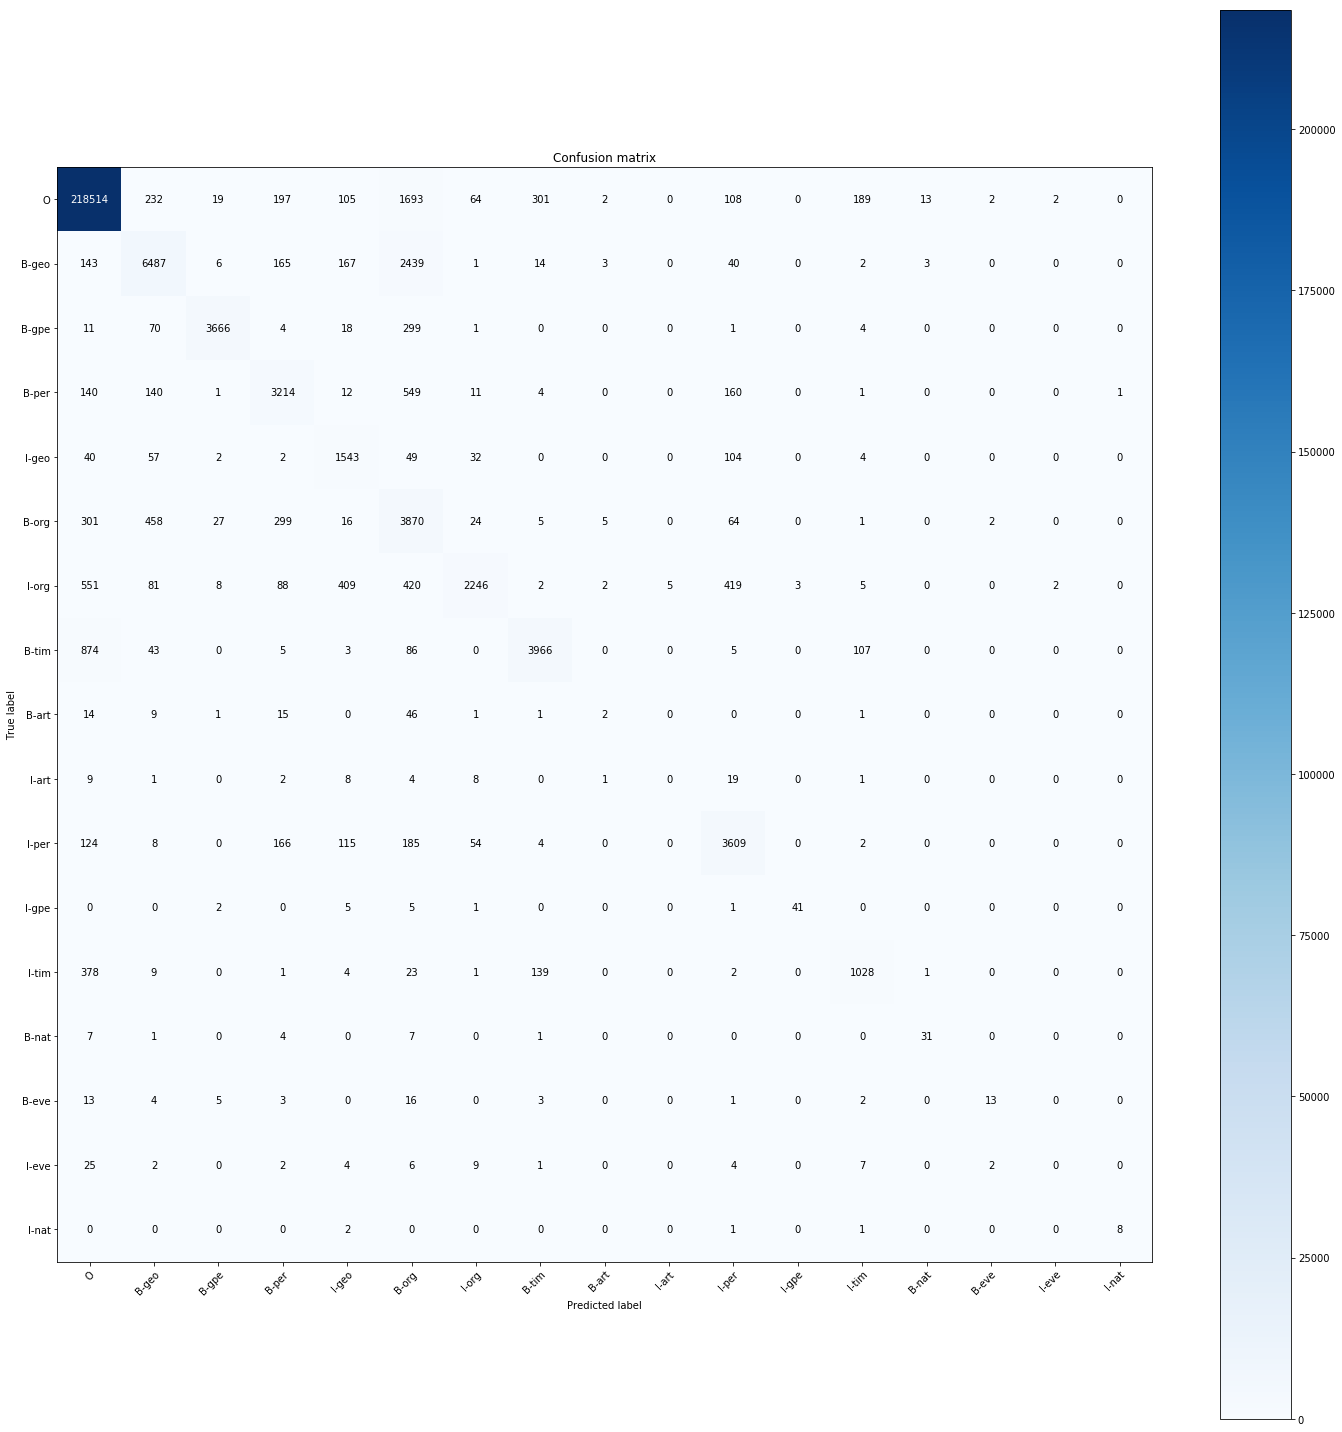

In [41]:
ax = plot_confusion_matrix(y_true, y_pred, classes=list(sp.state_labels),
                      title='Confusion matrix')

#### SENTENCES TO TEST THE MODEL

We think that these are the tags that the model should obtain:

1. The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O

2. The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/O checker./O

3. Jack/B-per London/I-per went/O to/O Parris./O

4. Jack/B-per London/I-per went/O to/O/O Paris./B-geo

5. We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O

6. We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O

7. The/O president/O of/O U.S.A/B-geo though/O they/O could/O win/O the/O war/O

8. The/O president/O of/O the/O United/B-geo States/B-geo of/B-geo America/B-geo though/O they/O could/O win/O the/O war/O

9. The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O

10. Robin/B-per does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia./I-geo


In [42]:
for sentence in test_sentences:
    new_seq = Sequence(x=sentence.split(), y=[int(0) for w in sentence.split()])
    print(sp.viterbi_decode(new_seq)[0].to_words(sequence_list_train, only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/B-org cannot/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./B-geo 
Jack/B-per London/B-geo went/O to/O Paris./B-geo 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A/B-org though/O they/O could/O win/O the/O war/O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/B-org does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia./I-per 


In [43]:
# Here we can select the sentence in which we want to compare the true and the predicted tags
# Select a sentence between 1 and 10
i=1
sentence = test_sentences[i-1]
new_seq = Sequence(x=sentence.split(), y=[int(0) for w in sentence.split()])
preds = sp.viterbi_decode(new_seq)[0].y
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for word, true_tag, pred_tag in zip(sentence.split(), test_tags[i-1], preds):
    print("{:15} ({:5}): {}".format(word, true_tag, pos_to_tag[pred_tag]))

Word            (True ): Pred
The             (O    ): O
programmers     (O    ): O
from            (O    ): O
Barcelona       (B-geo): B-org
might           (O    ): O
write           (O    ): O
a               (O    ): O
sentence        (O    ): O
without         (O    ): O
a               (O    ): O
spell           (O    ): O
checker.        (O    ): O


#### Capital checking

In [42]:
new_seq = Sequence(x=X_test[0], y=[int(0) for w in X_test[0]])
preds = sp.viterbi_decode(new_seq)[0].y
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for word, true_tag, pred_tag in zip(X_test[0], Y_test[0], preds):
    print("{:15} ({:5}): {}".format(word, true_tag, pos_to_tag[pred_tag]))

Word            (True ): Pred
Officials       (O    ): O
said            (O    ): O
Sunday          (B-tim): B-tim
Jean            (B-per): B-per
Rene            (I-per): I-per
Anthony         (I-per): I-per
was             (O    ): O
killed          (O    ): O
in              (O    ): O
a               (O    ): O
shootout        (O    ): O
with            (O    ): O
police          (O    ): O
near            (O    ): O
the             (O    ): O
capital         (O    ): O
city            (O    ): O
of              (O    ): O
Port-au-Prince  (B-geo): O
.               (O    ): O


##### Comments:

We have solved the problem with Heab Rene Anthony but now we have again problems with Port-au-Prince. As well, we have changed the output of Barcelona and now we have it wrong. In the next experiments we are going to fix this problem.

# EXPERIMENT 4:

##### Comments:

### Extended features

In [30]:
ex_feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(sequence_list_train) 
ex_feature_mapper.build_features()
pprint.pprint(list(ex_feature_mapper.__dict__.keys()))

['feature_dict',
 'feature_list',
 'add_features',
 'dataset',
 'node_feature_cache',
 'initial_state_feature_cache',
 'final_state_feature_cache',
 'edge_feature_cache']


In [31]:
len(ex_feature_mapper.feature_dict)

38332

In [32]:
ex_feature_mapper.feature_dict

{'init_tag:O': 0,
 'id:Thousands::O': 1,
 'hyphen::O': 2,
 'upper_ini::O': 3,
 'id:of::O': 4,
 'prev_tag:O::O': 5,
 'id:demonstrators::O': 6,
 'id:have::O': 7,
 'id:marched::O': 8,
 'id:through::O': 9,
 'id:London::B-geo': 10,
 'hyphen::B-geo': 11,
 'upper_ini::B-geo': 12,
 'prev_tag:O::B-geo': 13,
 'id:to::O': 14,
 'prev_tag:B-geo::O': 15,
 'id:protest::O': 16,
 'id:the::O': 17,
 'id:war::O': 18,
 'id:in::O': 19,
 'id:Iraq::B-geo': 20,
 'id:and::O': 21,
 'id:demand::O': 22,
 'id:withdrawal::O': 23,
 'id:British::B-gpe': 24,
 'hyphen::B-gpe': 25,
 'upper_ini::B-gpe': 26,
 'prev_tag:O::B-gpe': 27,
 'id:troops::O': 28,
 'prev_tag:B-gpe::O': 29,
 'id:from::O': 30,
 'id:that::O': 31,
 'id:country::O': 32,
 'id:.::O': 33,
 'final_prev_tag:O': 34,
 'id:Families::O': 35,
 'id:soldiers::O': 36,
 'id:killed::O': 37,
 'id:conflict::O': 38,
 'id:joined::O': 39,
 'id:protesters::O': 40,
 'id:who::O': 41,
 'id:carried::O': 42,
 'id:banners::O': 43,
 'id:with::O': 44,
 'id:such::O': 45,
 'id:slogans

In [34]:
[x for x in list(ex_feature_mapper.feature_dict.keys()) if 'upper_ini' in x]

['upper_ini::O',
 'upper_ini::B-geo',
 'upper_ini::B-gpe',
 'upper_ini::B-per',
 'upper_ini::I-geo',
 'upper_ini::B-org',
 'upper_ini::I-org',
 'upper_ini::B-tim',
 'upper_ini::B-art',
 'upper_ini::I-art',
 'upper_ini::I-per',
 'upper_ini::I-gpe',
 'upper_ini::B-nat',
 'upper_ini::I-eve',
 'upper_ini::B-eve',
 'upper_ini::I-nat',
 'upper_ini::I-tim']

#### Training structured perceptron

In [35]:
corpus = skseq.readers.pos_corpus.PostagCorpus()
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)

In [36]:
sp.get_num_states(), sp.get_num_observations()

(17, 30863)

In [37]:
%%time
num_epochs = 15
sp.fit(ex_feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.924172
Epoch: 1 Accuracy: 0.942038
Epoch: 2 Accuracy: 0.947037
Epoch: 3 Accuracy: 0.949941
Epoch: 4 Accuracy: 0.952224
Epoch: 5 Accuracy: 0.954083
Epoch: 6 Accuracy: 0.955238
Epoch: 7 Accuracy: 0.956123
Epoch: 8 Accuracy: 0.957504
Epoch: 9 Accuracy: 0.958145
Epoch: 10 Accuracy: 0.958737
Epoch: 11 Accuracy: 0.959585
Epoch: 12 Accuracy: 0.960322
Epoch: 13 Accuracy: 0.960582
Epoch: 14 Accuracy: 0.961382
Wall time: 1h 8min 23s


In [38]:
sp.save_model("perceptron_ex3")

In [39]:
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)
sp.load_model(dir="perceptron_ex3")

#### Testing

In [40]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

y_pred_2 = []
y_true = [item for x in Y_ids_test for item in x]
correct_sentences = 0
n_test = len(X_test)

for i in range(n_test):
    y_pred_aux = sp.predict_tags_given_words(X_test[i])
    y_pred_2.append(y_pred_aux)
    if list(y_pred_aux) == Y_ids_test[i]:
        correct_sentences += 1
    
y_pred = [item for x in y_pred_2 for item in x]
F1_score_multi = f1_score(y_true, y_pred, average=None)
Accuracy = accuracy_score(y_true, y_pred)
print('Accuracy for test is: ' + str(Accuracy))
print('F1-Score for test is: ' + str(np.mean(F1_score_multi)))
print('Correct sentences for test (%) : ' + str(correct_sentences/n_test))

Accuracy for test is: 0.9485992915254366
F1-Score for test is: 0.6063765749610461
Correct sentences for test (%) : 0.46137804471137805


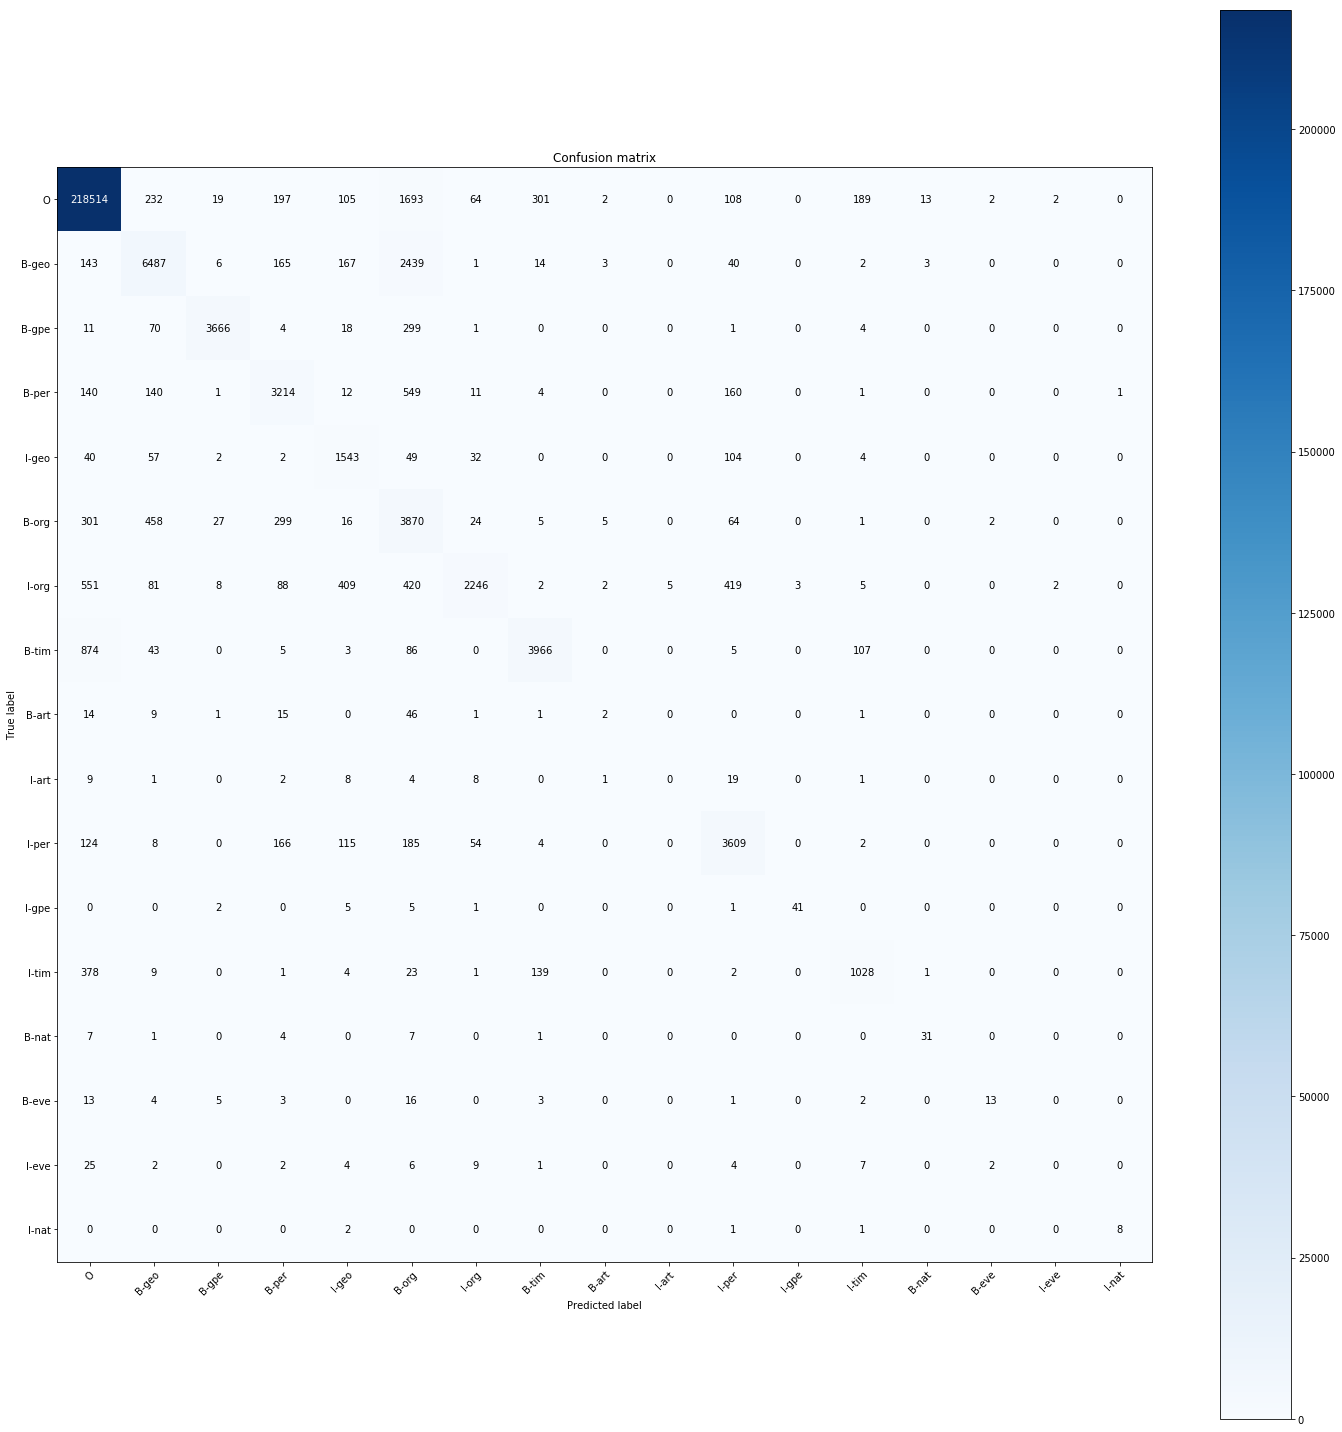

In [41]:
ax = plot_confusion_matrix(y_true, y_pred, classes=list(sp.state_labels),
                      title='Confusion matrix')

#### SENTENCES TO TEST THE MODEL

We think that these are the tags that the model should obtain:

1. The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O

2. The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/O checker./O

3. Jack/B-per London/I-per went/O to/O Parris./O

4. Jack/B-per London/I-per went/O to/O/O Paris./B-geo

5. We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O

6. We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O

7. The/O president/O of/O U.S.A/B-geo though/O they/O could/O win/O the/O war/O

8. The/O president/O of/O the/O United/B-geo States/B-geo of/B-geo America/B-geo though/O they/O could/O win/O the/O war/O

9. The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O

10. Robin/B-per does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia./I-geo


In [42]:
for sentence in test_sentences:
    new_seq = Sequence(x=sentence.split(), y=[int(0) for w in sentence.split()])
    print(sp.viterbi_decode(new_seq)[0].to_words(sequence_list_train, only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/B-org cannot/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./B-geo 
Jack/B-per London/B-geo went/O to/O Paris./B-geo 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A/B-org though/O they/O could/O win/O the/O war/O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/B-org does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia./I-per 


In [43]:
# Here we can select the sentence in which we want to compare the true and the predicted tags
# Select a sentence between 1 and 10
i=1
sentence = test_sentences[i-1]
new_seq = Sequence(x=sentence.split(), y=[int(0) for w in sentence.split()])
preds = sp.viterbi_decode(new_seq)[0].y
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for word, true_tag, pred_tag in zip(sentence.split(), test_tags[i-1], preds):
    print("{:15} ({:5}): {}".format(word, true_tag, pos_to_tag[pred_tag]))

Word            (True ): Pred
The             (O    ): O
programmers     (O    ): O
from            (O    ): O
Barcelona       (B-geo): B-org
might           (O    ): O
write           (O    ): O
a               (O    ): O
sentence        (O    ): O
without         (O    ): O
a               (O    ): O
spell           (O    ): O
checker.        (O    ): O


#### Capital checking

In [42]:
new_seq = Sequence(x=X_test[0], y=[int(0) for w in X_test[0]])
preds = sp.viterbi_decode(new_seq)[0].y
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for word, true_tag, pred_tag in zip(X_test[0], Y_test[0], preds):
    print("{:15} ({:5}): {}".format(word, true_tag, pos_to_tag[pred_tag]))

Word            (True ): Pred
Officials       (O    ): O
said            (O    ): O
Sunday          (B-tim): B-tim
Jean            (B-per): B-per
Rene            (I-per): I-per
Anthony         (I-per): I-per
was             (O    ): O
killed          (O    ): O
in              (O    ): O
a               (O    ): O
shootout        (O    ): O
with            (O    ): O
police          (O    ): O
near            (O    ): O
the             (O    ): O
capital         (O    ): O
city            (O    ): O
of              (O    ): O
Port-au-Prince  (B-geo): O
.               (O    ): O
